In [12]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats

### Data Collection

In [13]:
# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module3/exercise/module3_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module3/exercise/module3_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module3_exercise_train.csv')
download_file(test_data_url, 'module3_exercise_test.csv')

Downloaded module3_exercise_train.csv from https://www.raphaelcousin.com/modules/data-science-practice/module3/exercise/module3_exercise_train.csv
Downloaded module3_exercise_test.csv from https://www.raphaelcousin.com/modules/data-science-practice/module3/exercise/module3_exercise_test.csv


In [14]:
# Loading data
df_train =  pd.read_csv("module3_exercise_train.csv", sep=",", index_col='id')
X_test = pd.read_csv("module3_exercise_test.csv", sep=",", index_col='id')

print("训练数据形状:", df_train.shape)
print("测试数据形状:", X_test.shape)
print("\n训练数据列名:")
print(df_train.columns.tolist())

训练数据形状: (1168, 17)
测试数据形状: (292, 16)

训练数据列名:
['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


### Data Preprocessing

In [15]:
# 检查缺失值
print("\n缺失值统计:")
print(df_train.isnull().sum())

# Locating target_column
target_column = 'SalePrice'



缺失值统计:
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     1
Fireplaces       0
GarageYrBlt      0
GarageCars       1
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           1
SalePrice        0
dtype: int64


In [16]:
# Value conversion (from string to float)
def convert_garage_cars(value):
    """将GarageCars转换为数值"""
    if pd.isna(value):
        return 0.0

    # 如果已经是数值，直接返回
    if isinstance(value, (int, float)):
        return float(value)

    # 处理字符串类型的数值
    if isinstance(value, str):
        # 移除可能的空格和特殊字符
        value = value.strip()
        # 尝试转换为数值
        try:
            return float(value)
        except ValueError:
            # 如果是文字描述，进行映射
            mapping = {
                'none': 0, 'zero': 0, 'no': 0, 'null': 0,
                'one': 1, 'single': 1,
                'two': 2, 'double': 2,
                'three': 3, 'triple': 3,
                'four': 4, 'quad': 4,
                'five': 5, 'quint': 5
            }
            return mapping.get(value.lower(), 0.0)

    return 0.0

# 检查并转换GarageCars列
if 'GarageCars' in df_train.columns:
    print("\n=== GarageCars列转换 ===")
    print("转换前的数据类型:", df_train['GarageCars'].dtype)
    print("转换前的唯一值:", df_train['GarageCars'].unique())

    # 应用转换
    df_train['GarageCars'] = df_train['GarageCars'].apply(convert_garage_cars)

    print("转换后的数据类型:", df_train['GarageCars'].dtype)
    print("转换后的唯一值:", df_train['GarageCars'].unique())
    print("转换后的描述性统计:")
    print(df_train['GarageCars'].describe())

# 对测试集也进行同样的转换
if 'GarageCars' in X_test.columns:
    X_test_processed = X_test.copy()
    X_test_processed['GarageCars'] = X_test_processed['GarageCars'].apply(convert_garage_cars)
else:
    X_test_processed = X_test.copy()


=== GarageCars列转换 ===
转换前的数据类型: object
转换前的唯一值: ['two' 'one' 'three' 'zero' nan 'four']
转换后的数据类型: float64
转换后的唯一值: [2. 1. 3. 0. 4.]
转换后的描述性统计:
count    1168.000000
mean        1.755137
std         0.740532
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64


正常值范围: [1892.50, 2064.50]


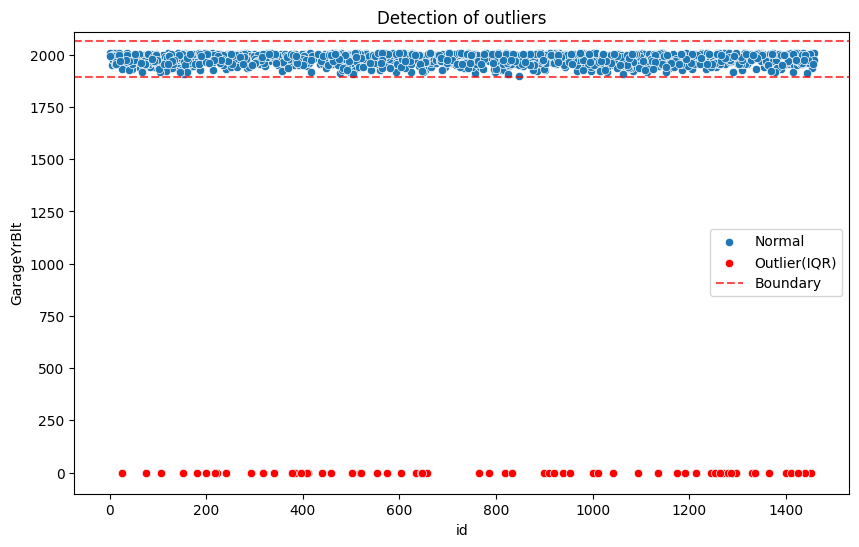


异常值处理结果:
原始数据量: 1168
清理后数据量: 1103
剔除异常值数量: 65
正常值范围: [1900.50, 2064.50]

异常值处理结果:
原始数据量: 292
清理后数据量: 276
剔除异常值数量: 16


In [17]:
# Detecting outliers with IQR-method
def detect_outliers_iqr(data, column, threshold=1.5):
    """使用IQR方法检测异常值"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# IQR-Method
outliers_iqr, lower_bound, upper_bound = detect_outliers_iqr(df_train, 'GarageYrBlt')
print(f"正常值范围: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train.index, y=df_train['GarageYrBlt'], label='Normal')
if len(outliers_iqr) > 0:
    sns.scatterplot(x=outliers_iqr.index, y=outliers_iqr['GarageYrBlt'],
                   color='red', label='Outlier(IQR)')
plt.axhline(y=upper_bound, color='r', linestyle='--', alpha=0.7, label='Boundary')
plt.axhline(y=lower_bound, color='r', linestyle='--', alpha=0.7)
plt.title('Detection of outliers')
plt.legend()
plt.show()

# Erase the outliers from df-train
original_size = len(df_train)
df_train_clean = df_train[(df_train['GarageYrBlt'] >= lower_bound) &
                         (df_train['GarageYrBlt'] <= upper_bound)].copy()

print(f"\n异常值处理结果:")
print(f"原始数据量: {original_size}")
print(f"清理后数据量: {len(df_train_clean)}")
print(f"剔除异常值数量: {original_size - len(df_train_clean)}")

# Erase the outliers from X_test_processed
outliers_iqr, lower_bound, upper_bound = detect_outliers_iqr(X_test_processed, 'GarageYrBlt')
print(f"正常值范围: [{lower_bound:.2f}, {upper_bound:.2f}]")
original_size = len(X_test_processed)
X_test_clean = X_test_processed[(X_test_processed['GarageYrBlt'] >= lower_bound) &
                         (X_test_processed['GarageYrBlt'] <= upper_bound)].copy()

print(f"\n异常值处理结果:")
print(f"原始数据量: {original_size}")
print(f"清理后数据量: {len(X_test_clean)}")
print(f"剔除异常值数量: {original_size - len(X_test_clean)}")

In [18]:
def preprocess_data(df, target_column=None, is_train=True):
    """完整的数据预处理函数"""
    df_processed = df.copy()

    # 1. 处理GarageCars列（如果存在）
    if 'GarageCars' in df_processed.columns:
        df_processed['GarageCars'] = df_processed['GarageCars'].apply(convert_garage_cars)

    # 2. 删除不必要的列
    columns_to_drop = ['col1']  # 可以根据实际情况调整
    existing_cols_to_drop = [col for col in columns_to_drop if col in df_processed.columns]
    if existing_cols_to_drop:
        df_processed = df_processed.drop(columns=existing_cols_to_drop)

    # 3. 分离特征和目标变量（如果是训练数据）
    if is_train and target_column and target_column in df_processed.columns:
        y = df_processed[target_column]
        X = df_processed.drop(columns=[target_column])
    else:
        X = df_processed
        y = None

    # 4. 处理缺失值
    # 数值列用中位数填充
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if X[col].isnull().sum() > 0:
            median_val = X[col].median()
            X[col] = X[col].fillna(median_val)

    # 分类列用众数填充
    categorical_columns = X.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if X[col].isnull().sum() > 0:
            mode_val = X[col].mode()[0] if len(X[col].mode()) > 0 else 'Unknown'
            X[col] = X[col].fillna(mode_val)

    # 5. 编码分类变量
    X_encoded = pd.get_dummies(X, prefix_sep='_', drop_first=True)

    return (X_encoded, y) if is_train else X_encoded

# 应用预处理
print("\n=== 数据预处理 ===")
X_processed, y_processed = preprocess_data(df_train_clean, target_column, is_train=True)
X_test_clean = preprocess_data(X_test_clean, is_train=False)

print(f"预处理后训练特征形状: {X_processed.shape}")
print(f"预处理后测试特征形状: {X_test_processed.shape}")

# 确保特征一致性
common_columns = X_processed.columns.intersection(X_test_clean.columns)
X_processed = X_processed[common_columns]
X_test_clean = X_test_clean[common_columns]

# 添加缺失的列
missing_cols_train = set(X_test_clean.columns) - set(X_processed.columns)
missing_cols_test = set(X_processed.columns) - set(X_test_clean.columns)

for col in missing_cols_test:
    X_test_clean[col] = 0

X_test_clean = X_test_clean[X_processed.columns]

print(f"对齐后训练特征形状: {X_processed.shape}")
print(f"对齐后测试特征形状: {X_test_clean.shape}")


=== 数据预处理 ===
预处理后训练特征形状: (1103, 16)
预处理后测试特征形状: (292, 16)
对齐后训练特征形状: (1103, 16)
对齐后测试特征形状: (276, 16)


### Model Building and Evaluation

In [19]:
# 分割训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

print("=== 模型训练 ===")
print(f"训练集大小: {X_train.shape}")
print(f"验证集大小: {X_val.shape}")

# 线性回归模型
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 随机森林模型（可选）
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 模型评估
def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)

    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    return y_pred

print("\n=== 模型性能 ===")
print("训练集性能:")
lr_train_pred = evaluate_model(lr_model, X_train, y_train, "线性回归")
rf_train_pred = evaluate_model(rf_model, X_train, y_train, "随机森林")

print("\n验证集性能:")
lr_val_pred = evaluate_model(lr_model, X_val, y_val, "线性回归")
rf_val_pred = evaluate_model(rf_model, X_val, y_val, "随机森林")

# 选择更好的模型（基于验证集MAE）
lr_mae = mean_absolute_error(y_val, lr_val_pred)
rf_mae = mean_absolute_error(y_val, rf_val_pred)

best_model = lr_model if lr_mae < rf_mae else rf_model
best_model_name = "线性回归" if lr_mae < rf_mae else "随机森林"
print(f"\n选择的最佳模型: {best_model_name}")


=== 模型训练 ===
训练集大小: (882, 16)
验证集大小: (221, 16)

=== 模型性能 ===
训练集性能:
线性回归 - MAE: 31893.09, RMSE: 46353.19
随机森林 - MAE: 10501.15, RMSE: 16243.30

验证集性能:
线性回归 - MAE: 29701.00, RMSE: 40805.66
随机森林 - MAE: 25394.04, RMSE: 37406.49

选择的最佳模型: 随机森林


### Generating Submission File

In [21]:
# 在完整训练集上重新训练最佳模型
best_model.fit(X_processed, y_processed)

# 测试集预测
y_pred_test = best_model.predict(X_test_clean)

# 生成提交文件
submission = pd.DataFrame({
    'id': X_test_clean.index,
    'SalePrice': y_pred_test
})

submission.to_csv('submission.csv', index=False, sep=',')
print("\n=== 提交文件生成完成 ===")
print(f"文件已保存: submission.csv")
print("前5行预览:")
print(submission.head())

# 预测结果统计
print(f"\n预测结果统计:")
print(f"预测值范围: [{y_pred_test.min():.2f}, {y_pred_test.max():.2f}]")
print(f"预测值均值: {y_pred_test.mean():.2f}")


=== 提交文件生成完成 ===
文件已保存: submission.csv
前5行预览:
     id  SalePrice
0   892  275971.29
1  1105  191912.58
2   413  167930.00
3   522  191636.55
4  1036  176596.75

预测结果统计:
预测值范围: [101173.80, 454359.54]
预测值均值: 188800.54
